# Feature Ranking

Feature selection is a very important part of churn analysis because management need to identify pain points, and come up with strategy for customer retension. However, as we can see in this notebook, there is no one size fit all method for feature ranking. Algorithm like XGBoostClassifier has a feature importance method, but its ranking can often be skewed by features that have been used with high frequency. Here, I will compare the result of linear method (Logistic Regression), stability method (Randomized Logistic Regression), recursive feature elimination (with SVM and Logistic Regression), and tree method (Decision Tree and Random Forest).

One major caveat here is that our data contain a categorical entry---state and area code, that can drastically increase the dimension of our data, once we apply One-Hot-Encoding, in order to feed the data into linear model. Such encoding also skews the result (to almost zero importance) for tree method because it reduces the usage of each resulting new features from One-Hot-Encoding. Luckily, in this dataset, the feature "state" and "area code" do not have a big enough contribution to the classification task. Thus, for the sake of simplicity, I will drop them in the subsequent discussion when making the feature ranking matrix. 

**Disclaimer**: For the feature ranking matrix, I use with modification some of the codes from fellow Kaggler Anisotropic's [kernel](https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models). However, his discussion is on regression model that does not contain any categorical data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
pd.set_option('display.max_columns',100)
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, f_classif
from sklearn.linear_model import RandomizedLogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Helper function
from sklearn.pipeline import TransformerMixin, make_pipeline

class Drop_columns(TransformerMixin):
    
    def __init__(self, columns=None):
        self.columns = columns
        
    def transform(self, X, y=None, **kwargs):
        try:
            return X.drop(self.columns, axis=1)
        except ValueError:
            print ('No such columns!')
            
    def fit(self, X, y=None, **kwargs):
        return self

class DummyEncoder(TransformerMixin):

    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, y=None, **kwargs):
        return pd.get_dummies(X, columns=self.columns, drop_first=True)

    def fit(self, X, y=None, **kwargs):
        return self
    
class Encoder(TransformerMixin):
    
    def __init__(self, columns=None):        
        self.columns = columns
    
    def transform(self, X, y=None, **kwargs):       
        le = LabelEncoder()
        for col in self.columns:
            X[col] = le.fit_transform(X[col])
        return X
    
    def fit(self, X, y=None, **kwargs):        
        return self

def display_result(X_train, X_test, y_train, y_test, clf, display_roc=True):
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print (classification_report(y_test, y_pred))


    matrix = pd.DataFrame(
           confusion_matrix(y_test,y_pred),
            columns=['Predicted False', 'Predict True'],
            index = ['Actual False', 'Actual True'])
    display(matrix)
    
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    if display_roc:
        
        plt.plot(fpr, tpr,label='%s (area = %0.2f)' % ('LogisticRegression', roc_auc_score(y_test, y_pred)))
        # Plot Base Rate ROC
        plt.plot([0,1], [0,1],label='Base Rate' 'k--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Graph')
        plt.legend(loc="lower right")
        plt.show()
        return
    return fpr, tpr, thresholds, y_pred


def read_data(onehot=False, label=False, return_cat_columns=False):
    df = pd.read_csv('churn.csv')
    df.columns = df.columns.str.lower().str.replace(' ','_')
    df.rename(columns={'churn?':'churn', "int'l_plan":'intl_plan'}, inplace=True)
    df = (df.drop(['phone','day_charge','eve_charge','night_charge','intl_charge'], axis=1)
            .replace(['True.','False.'],[1,0]))
    df.area_code = df.area_code.astype('object')
    if label:
        df = df.replace(['yes','no'],[1,0])
    if onehot:
        df = pd.get_dummies(df, columns=['state','area_code'], drop_first=True)
    if return_cat_columns:
        return df, df.dtypes[df.dtypes==object].index.values.tolist()
    else:
        return df

## 1. Analyzing the State Feature

Since the feature "state" presents an unnecessary complication to our feature ranking task, let's first check just how much influence it has on our binary classification task. For simplicity, we can see how much does our prediction result differs with or without such feature. Here, we also use the sklearn's pipeline tools to help streamline our model. 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

df = read_data()
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1), df.churn.values, test_size=0.2,
                                                   random_state=0)

Linear Regression

             precision    recall  f1-score   support

          0       0.96      0.60      0.74       579
          1       0.24      0.83      0.37        88

avg / total       0.86      0.63      0.69       667



,Predicted False,Predict True
Actual False,350,229
Actual True,15,73


Linear Regression with State Column Dropped

             precision    recall  f1-score   support

          0       0.97      0.63      0.76       579
          1       0.27      0.89      0.41        88

avg / total       0.88      0.66      0.72       667



,Predicted False,Predict True
Actual False,364,215
Actual True,10,78


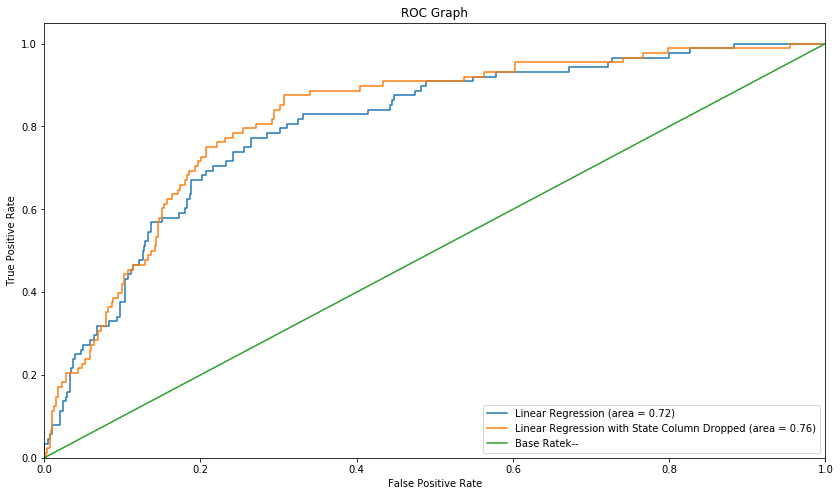

In [4]:
plt.figure(figsize=(14,8))

lr = make_pipeline(DummyEncoder(), StandardScaler(), LogisticRegression(fit_intercept=False))
lrd = make_pipeline(Drop_columns(columns=['state','area_code']),
                    Encoder(columns=['intl_plan', 'vmail_plan']),
                    StandardScaler(),
                    LogisticRegression(fit_intercept=False))
model = [('Linear Regression', lr), ('Linear Regression with State Column Dropped', lrd)]

for model_name, clf in model:
    print (model_name)
    print ()
    fpr, tpr, thresholds, y_pred = display_result(X_train, X_test, y_train, y_test, clf, display_roc=False)
    plt.plot(fpr, tpr,label='%s (area = %0.2f)' % (model_name, roc_auc_score(y_test, y_pred)))
    

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")

plt.show()

This is interesting, dropping the columns "state" does make a difference to our prediction result, but for the better! We can speculate that such feature may contain mostly noise. 

In [6]:
df = read_data(label=True)
y = df.churn.values
X = df.drop(['churn','state','area_code'], axis=1)
colnames = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
# Define dictionary to store our rankings
ranks = {}

# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return list(zip(names, ranks))

### Linear Method

In [34]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X, y)
ranks['Logistic'] = ranking(lr.coef_[0], colnames)

### Stability Method

In [35]:
rlogit = RandomizedLogisticRegression()
rlogit.fit(X, y)
ranks["rlogit/stability"] = ranking(np.abs(rlogit.scores_), colnames)
print('finished!')

finished!


### Recursive Feature Elimination Method

Here we use both Support Vector Machine (SVM) and Logistic Regression.

In [36]:
svc = SVC(kernel='linear')
rfec = RFE(svc, n_features_to_select=1)
rfec.fit(X, y)
ranks['RFE_SVC'] = ranking(list(map(float, rfec.ranking_)), colnames, order=-1)
print ('finished!')

finished!


In [37]:
lr = LogisticRegression(fit_intercept=False)
rfec = RFE(lr, n_features_to_select=1)
rfec.fit(X, y)
ranks['RFE_Logit'] = ranking(list(map(float, rfec.ranking_)), colnames, order=-1)
print ('finished!')

finished!


### Tree Method

We use both Decision Tree Classifier and Random Forest Classifier here.

In [38]:
dt = DecisionTreeClassifier()
dt.fit(X,y)
ranks['DTree'] = ranking(dt.feature_importances_, colnames)

In [39]:
rf = RandomForestClassifier()
rf.fit(X, y)
ranks['RForest'] = ranking(rf.feature_importances_, colnames)

### Putting all together

In [53]:
r = pd.DataFrame(colnames, columns=['feature'])
for name in ranks.keys():
    tmp = pd.DataFrame(ranks[name], columns=['feature',name])
    r = pd.merge(r,tmp, how='inner', on='feature')
    
r['Mean Ranking'] = round(r.mean(axis=1),2)

r.set_index('feature')

,Logistic,rlogit/stability,RFE_SVC,RFE_Logit,DTree,RForest,Mean Ranking
feature,,,,,,,
account_length,0.41,0.00,0.75,0.17,0.07,0.13,0.25
intl_plan,1.00,1.00,0.42,1.00,0.22,0.27,0.65
vmail_plan,0.00,0.46,1.00,0.75,0.17,0.00,0.40
vmail_message,0.54,0.24,0.92,0.58,0.00,0.05,0.39
day_mins,0.83,1.00,0.83,0.83,1.00,1.00,0.92
day_calls,0.42,0.00,0.00,0.25,0.03,0.13,0.14
eve_mins,0.60,0.55,0.17,0.67,0.49,0.40,0.48
eve_calls,0.39,0.00,0.33,0.00,0.05,0.10,0.14
night_mins,0.48,0.00,0.08,0.33,0.13,0.17,0.20


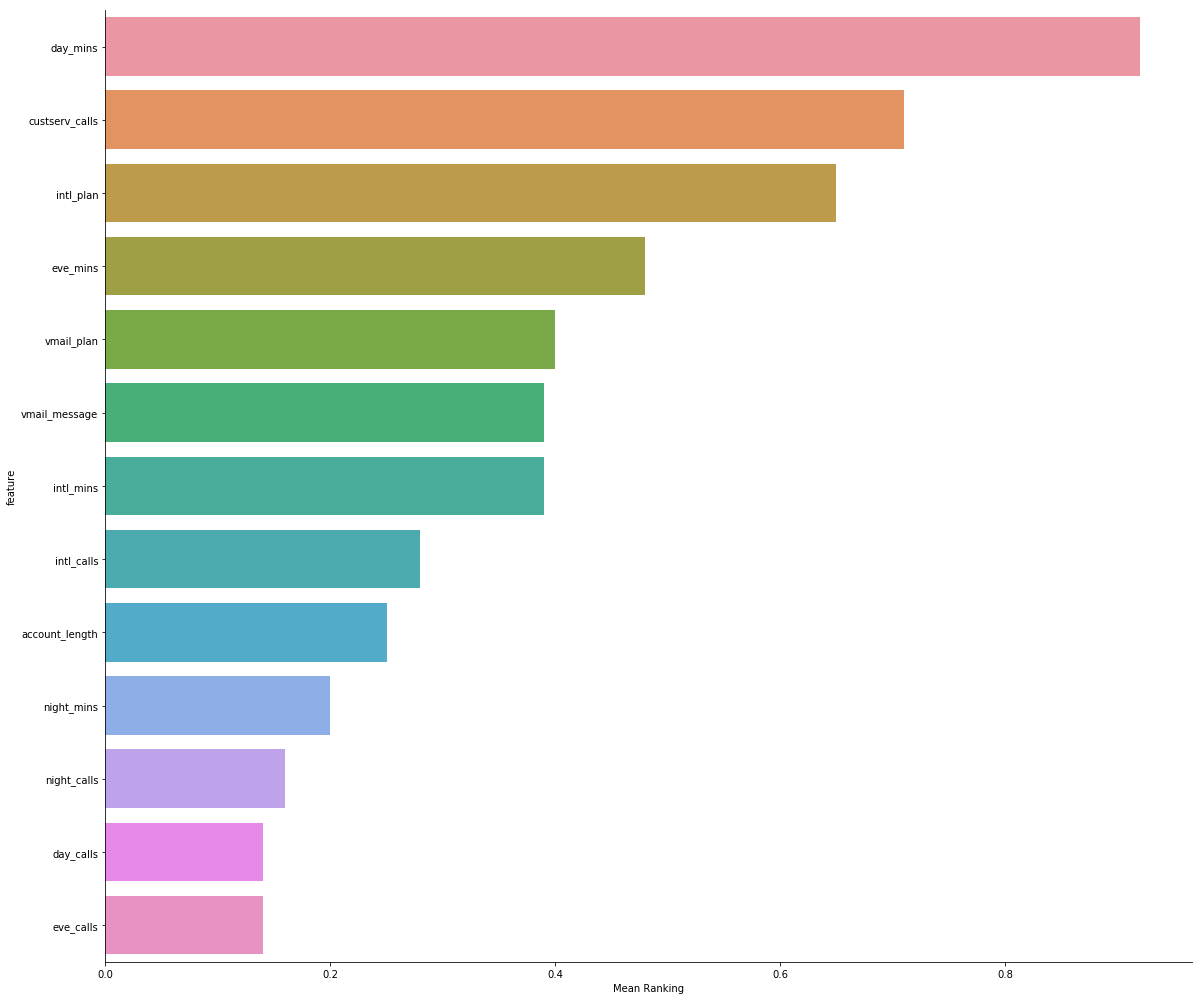

In [55]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="feature", data = r.sort_values(by='Mean Ranking',ascending=False), kind="bar", 
               size=14, aspect=1.2);

Recall from the previous notebook that we notice four features standout: vmail_plan, intl_plan, day_mins, custserv_call. This conclusion almost match what we have found here, with the exception of eve_mins. Thus, with some degree of confident, we can say that day_mins, custserv_calls, intl_plan are the top three reason customer leave.

It worths pointing out the result of tree method differ a bit with the linear method, while intl_plan ranks on the top for Logistic Regression, but it ranks low for both Decision Tree and Random Forest.

In fact, such disparity is also true for XGBoost Classifier. It has to with how feature importance is calculated for the tree method. Even though one features play important role at splitting the tree early on, but it may not be used as much on other nodes, so it has less of a aggregate effect, hence, lower feature importance.

We can demonstrate this effect with the following chart, using XGBoost's plot_tree method.

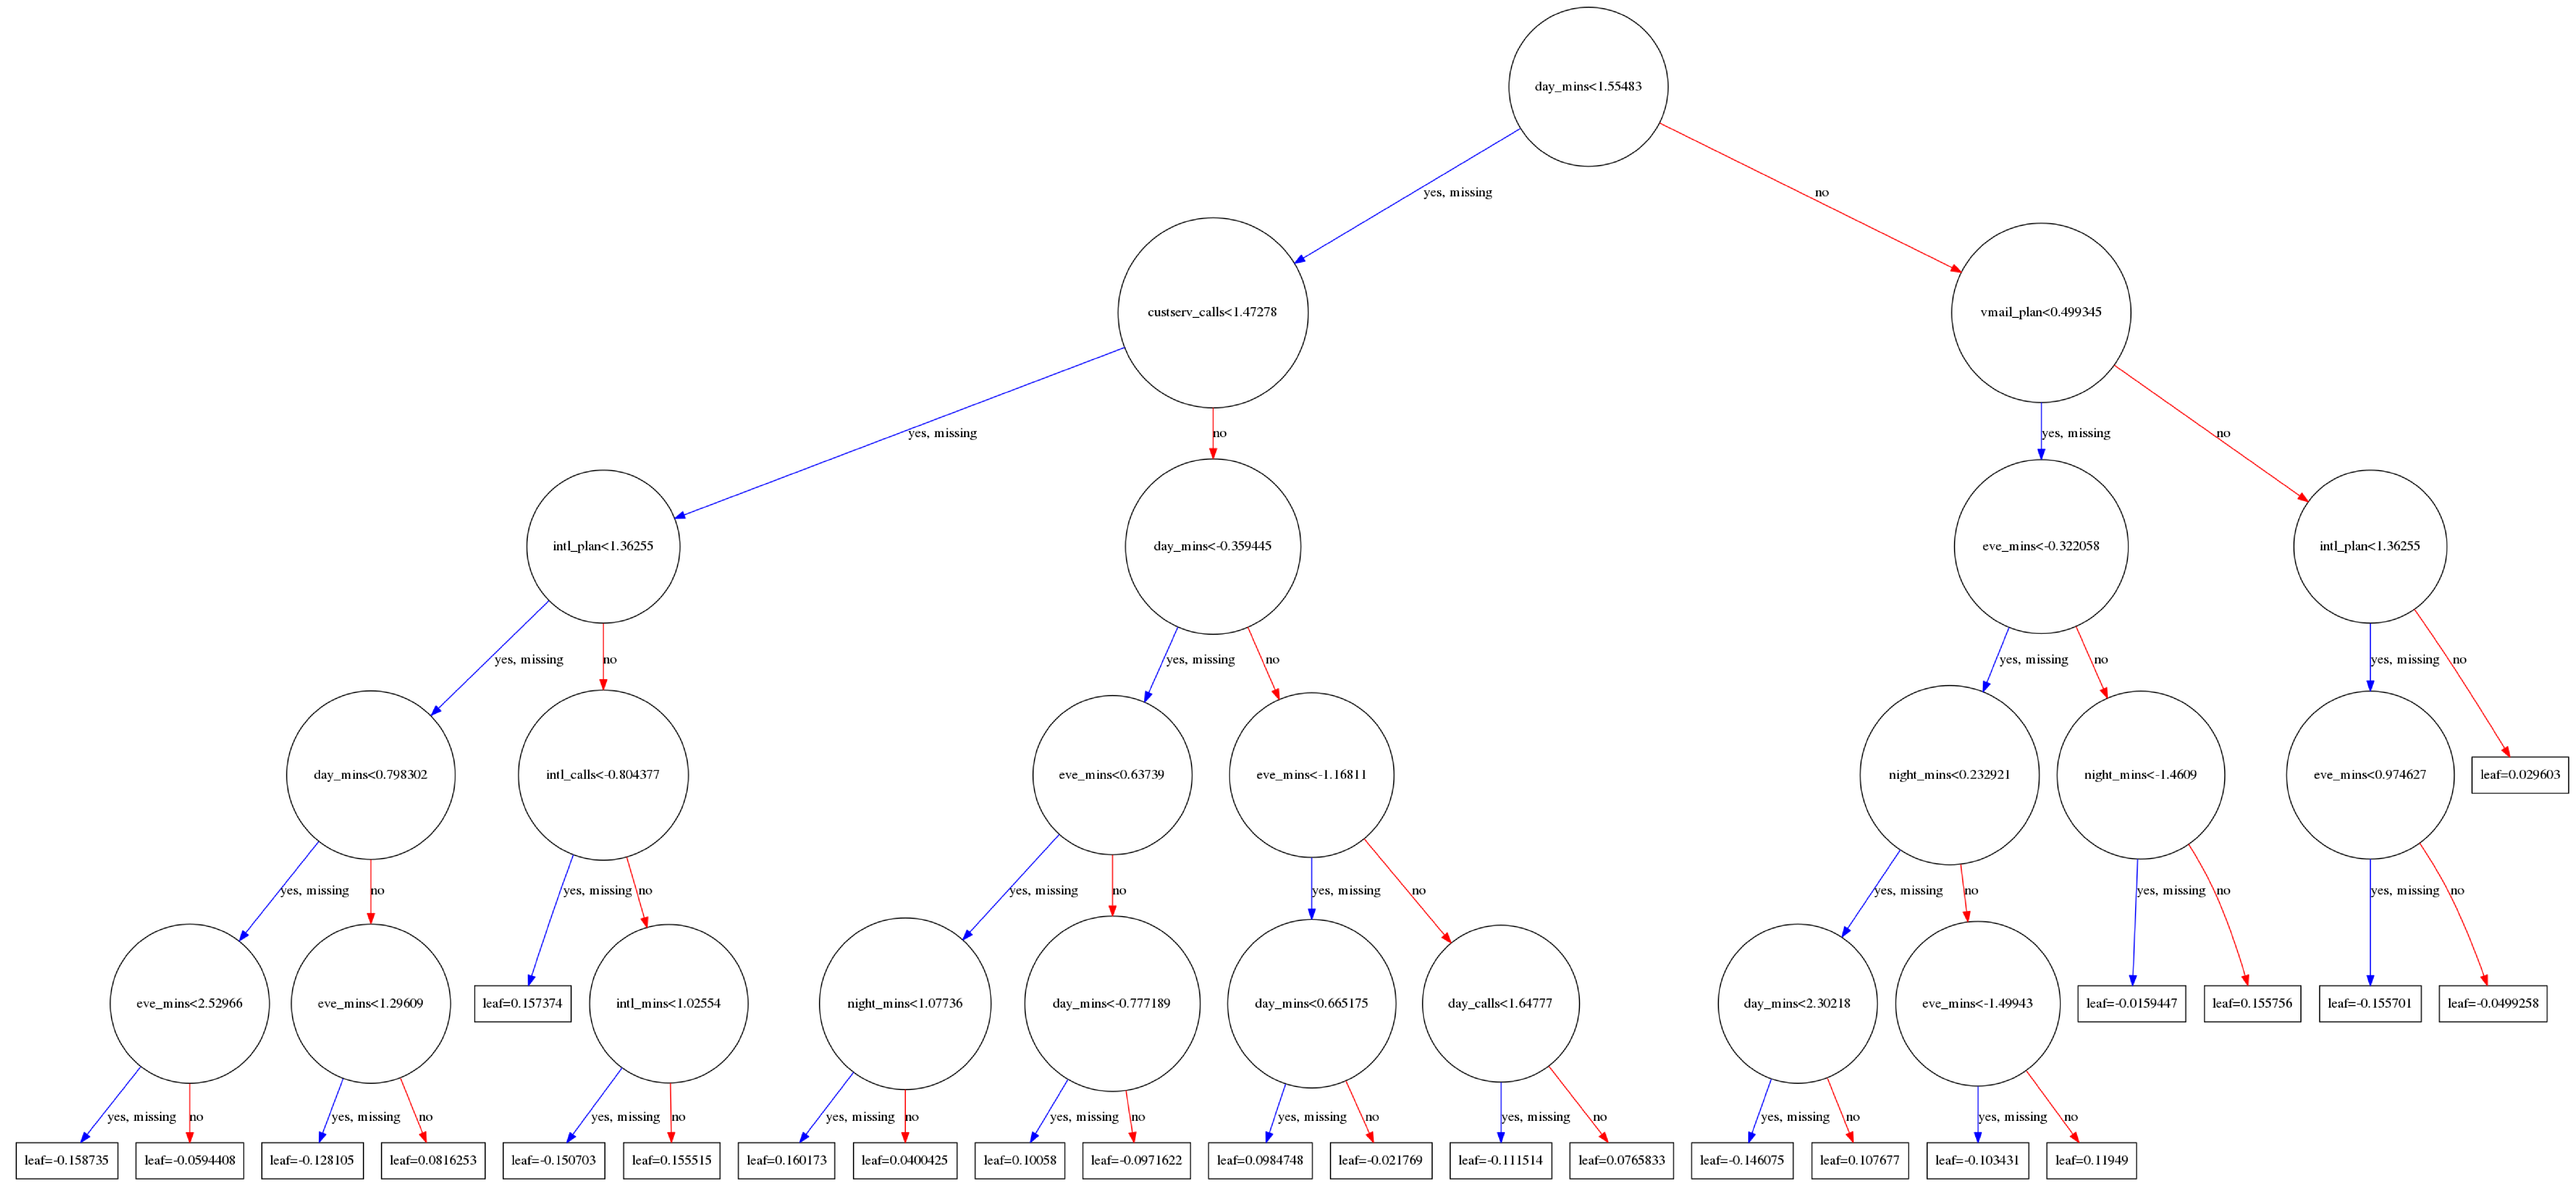

In [63]:
from xgboost import plot_tree
import xgboost as xgb
X_df = pd.DataFrame(X, columns=colnames)
clf = XGBClassifier(max_depth=5).fit(X_df, y)
xgb.plot_tree(clf, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
#fig.savefig('tree.png')

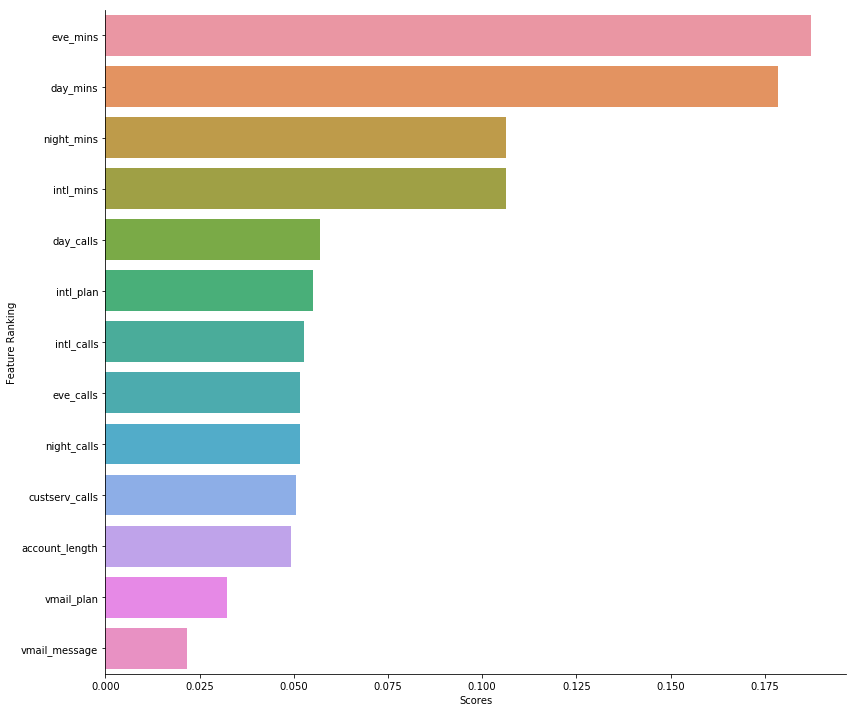

In [62]:
importance = (pd.DataFrame(list(zip(colnames,clf.feature_importances_)),
                          columns=['Feature Ranking','Scores'])
              .sort_values(by='Scores',ascending=False))
sns.factorplot(y='Feature Ranking',x='Scores', data=importance,kind='bar',size=10, aspect=1.2)

Here, although custserv_call is used as criterion for splitting the tree on the second level. However, it ranks low in the overall feature importance ranking. 

This is something important to watch out for in practice because important business decisions are being made with such analysis. Give the difference in ranking for various methods, it is both important and worthwhile to try multiple methods.